# <center> AI Final Presentation </center>

### <center> Team1 </center>

### <center> 17102060 Hwang Donggyu </center>

### <center> 18102077 Park JeongHa </center>


# **[1] Motivation for the Project**

*   With the development of artificial intelligence, content using deep fake technology is increasing.

*   Deepfake is abused for digital crimes, causing serious side effects and social problems.

*   In fact, it is frequently used in crimes such as false speeches synthesizing politicians' faces and producing and distributing pornographs featuring celebrities.

*   Therefore, we tried to detect deepfake images generated by using deep learning technologies we learned in this course. 

### A political abuse case of Deepfake

<img src="https://flexible.img.hani.co.kr/flexible/normal/879/652/imgdb/original/2020/0109/191578557685.png" width="400">

### A positive use case of Deepfake

<img src="https://img.hankyung.com/photo/202103/01.25592623.1.gif" width="245">

<img src="https://img.hankyung.com/photo/202103/01.25592629.1.jpg" width="250">

<img src="https://img.hankyung.com/photo/202103/01.25592630.1.jpg" width="250">



# [2] **Problem Description**

## - Deepfake Detection Challenge
*   Identify videos with facial manipulations






# [3] **Data Description**

*   Deepfake Detection Challenge Dataset (DFDC)
*   The data consists of a lot of video (.mp4) files including human face, and a metadata (.json) that matches each set of video files with its label (REAL/FAKE). 
*   The size of the data we used is 11.52 gigabytes. 
*   produced with several Deepfake, GAN-based, and non-learned 
methods
*   can be downloaded from 
https://ai.facebook.com/datasets/dfdc
*   We try to predict whether or not a particular video is a deepfake, it means, each video file has a label name of 0 or 1.


metadata.json
```
"aapnvogymq.mp4":{ 
"label":string "FAKE"
"split":string "train"
"original":string"jdubbvfswz.mp4"
}
"abarnvbtwb.mp4":{ 
"label":string "REAL"
"split":string "train"
"original":NULL
}
```



# [4] **Detection Process**

1.   Read the video frame by frame.
2.   For each frame image, extract the only face part and crop to a certain standard size.
3.   In this way, we generate 20 frame images per video.
4.   Calculate the Gaussian Blur noise for cropped images using openCV library. 
The Gaussian Blur noise represents the difference between original image and Gaussian Blurred Version image.
5.   Using this, build the feature map. Every video becomes an matrix of (20,100,100)
6.   Feed these feature sets into the model and learn the model for detection


# **[5] Preprocessing**
We focus on **how to extract the face area from entire image**.

We adapt two different approaches and compare them.

1.   Extract only eye, nose, mouth area. 
2.   Extract whole face area

We build the feature vectors using these two different approaches and train model for each. And compare the performance of models.

# [6] **Model Architecture**

## - Model 1: Convolutional Neural Network (3d-CNN)
a model consisting of three convolutional layers and max pooling layers.

## - Model 2: Gated Recurrent Units (GRUs)
a model consisting of four GRU layer with Dropout regularisation


## - Architecture choices 
*   Last layer **activation** function: Sigmoid
*   **Optimizer**: RMSprop
*   **Loss** function: Binary Cross Entropy

# [7] **Implementation**

In [ ]:
import numpy as np
from numpy import savetxt
import pandas as pd
import os
from time import time
import cv2

#use haarcascade xml files
face_cascade = cv2.CascadeClassifier('C:\\Users\\123\\Downloads/dfdc_train_part_49/dfdc_train_part_49/haarcascade_frontface.xml')
eye_cascade = cv2.CascadeClassifier('C:\\Users\\123\\Downloads/dfdc_train_part_49/dfdc_train_part_49/haarcascade_mcs_eyepair_big.xml')
nose_cascade = cv2.CascadeClassifier('C:\\Users\\123\\Downloads/dfdc_train_part_49/dfdc_train_part_49/haarcascade_mcs_nose.xml')
mouth_cascade = cv2.CascadeClassifier('C:\\Users\\123\\Downloads/dfdc_train_part_49/dfdc_train_part_49/mouth.xml')

from tqdm.notebook import tqdm
from mtcnn import MTCNN
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import random
import copy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
import tensorflow.keras as tfk
from tensorflow.keras import layers
tfkl = tfk.layers
from tensorflow.keras.optimizers import SGD

In [ ]:
INPUT_PATH = 'C:\\Users\\123\\Downloads/dfdc_train_part_49/dfdc_train_part_49'
metadata = pd.read_json(os.path.join(INPUT_PATH, 'metadata.json')).T

In [ ]:
metadata.head()

,label,split,original
dwwytkheyx.mp4,FAKE,train,nlcqykqsdp.mp4
bdsxxaamze.mp4,FAKE,train,xzmplldajk.mp4
tfceaqvefa.mp4,FAKE,train,zkksmnscsf.mp4
lurozpmsqd.mp4,FAKE,train,urbulrzowx.mp4
jvlvkijuwa.mp4,FAKE,train,wvnjcwevzo.mp4


In [ ]:
FILES = metadata.index
LABELS = metadata.label
print(FILES[0])

dwwytkheyx.mp4


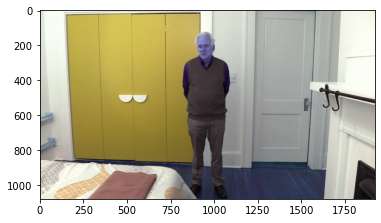

In [ ]:
#try on image
fn = FILES[1]
video_path = os.path.join(INPUT_PATH, fn)
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
im = image.copy()
im.shape
plt.imshow(im)

In [ ]:
#Extracting faces from video frames for standardized size
#frontface

def extract_frontface(frame):
    face_rects = face_cascade.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    if len(face_rects)==0:
        roi1 = np.empty((100,100,3))
        roi1[:]=np.nan
        return roi

    for (x,y,w,h) in face_rects: 
        roi = frame[y:y+h,x:x+w]

    std_roi_face=cv2.resize(roi, (100,100), interpolation=cv2.INTER_AREA)
    return std_roi_face

In [ ]:
#Extracting faces from video frames for standardized size
#face (only eyes, nose, mouth)

def extract_face(frame):
    eye_rects = eye_cascade.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    if len(eye_rects)==0:
        roi1 = np.empty((100,20,3))
        roi1[:]=np.nan
        return roi1
    nose_rects = nose_cascade.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    if len(nose_rects)==0:
        roi2 = np.empty((100,20,3))
        roi2[:]=np.nan
        return roi2
    mouth_rects = mouth_cascade.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    if len(mouth_rects)==0:
        roi3 = np.empty((100,20,3))
        roi3[:]=np.nan
        return roi3
    for (x,y,w,h) in eye_rects: 
        roi1 = frame[y:y+h,x:x+w]
    for (x,y,w,h) in nose_rects: 
        roi2 = frame[y:y+h,x:x+w]
    for (x,y,w,h) in mouth_rects: 
        roi3 = frame[y:y+h,x:x+w]

    std_roi1=cv2.resize(roi1, (100,20), interpolation=cv2.INTER_AREA)
    std_roi2=cv2.resize(roi2, (100,20), interpolation=cv2.INTER_AREA)
    std_roi3=cv2.resize(roi3, (100,20), interpolation=cv2.INTER_AREA)
    std_roi = np.concatenate((std_roi1, std_roi2, std_roi3), axis=1)
    return std_roi

(100, 100, 3)
(20, 300, 3)


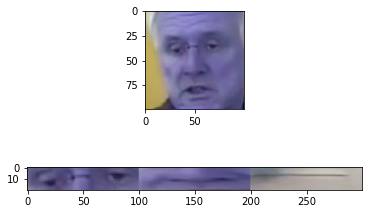

In [ ]:
a = extract_frontface(im)
b = extract_face(im)
print(a.shape)
print(b.shape)
plt.subplot(211)
plt.imshow(a)
plt.subplot(212)
plt.imshow(b)

frames size: (20, 100, 100, 3)


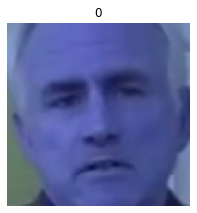

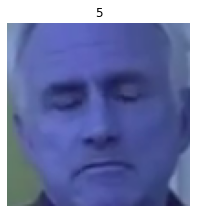

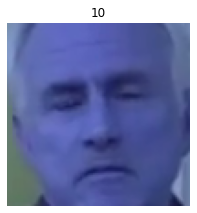

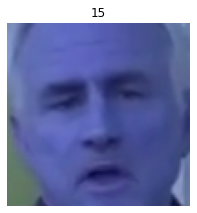

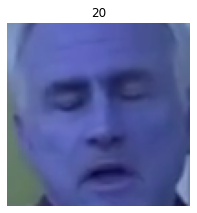

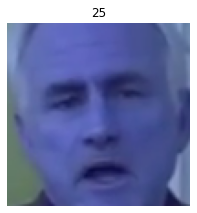

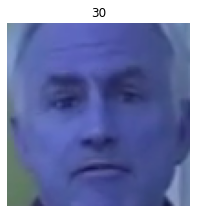

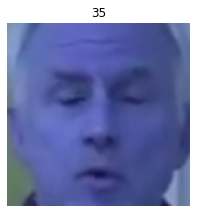

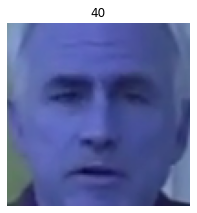

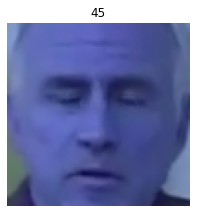

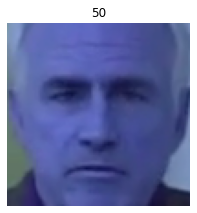

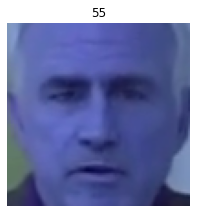

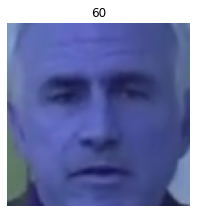

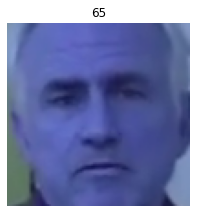

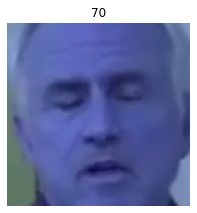

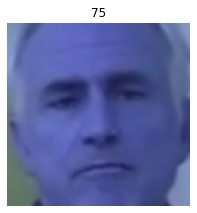

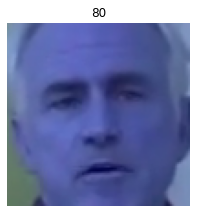

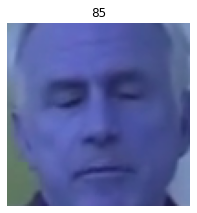

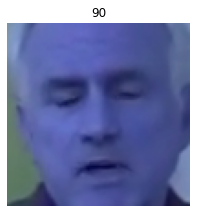

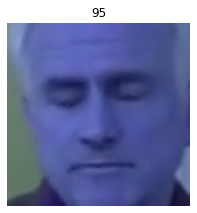

In [ ]:
%matplotlib inline
#input the video files and get 20 faces crop images
#if there's no face detection, return np.empty

#Extract face for each 5 frames. And get 20 face samples.

def crop_faces(fn,cnt_limit=20, plot=False, itr_limit = 250):
    faces=[]
    video_path = os.path.join(INPUT_PATH, fn)
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    itr = 0
    empty_faces = np.empty((20,100,100,3));empty_faces[:]=np.nan;
    while success:
        # Extract 20 faces
        itr+=1
        if itr>=itr_limit and count<cnt_limit*5:
            return empty_faces
            
        #every 5 frames, store captured face; if no face, continue capturing but don't add "count"
        if count%5 ==0:
            face = extract_frontface(image)
            if np.isnan(face).any():
                success,image = vidcap.read()
                continue #if there's no face detected, then capture next face and not count do not increase
            else:
                faces.append(face)
                if plot:
                    plt.figure(figsize=(80,80))
                    plt.subplot(cnt_limit,1,int(count/5)+1)
                    plt.title(str(count))
                    plt.axis('off')
                    plt.imshow(face)
        success,image = vidcap.read()
        count += 1
        if count >=cnt_limit*5:
            break
    if len(faces)<cnt_limit:
        return empty_faces
    return np.asarray(faces)

fn = FILES[2]
frames = crop_faces(fn,plot=True)
print("frames size:",frames.shape)

frames size: (20, 20, 300, 3)


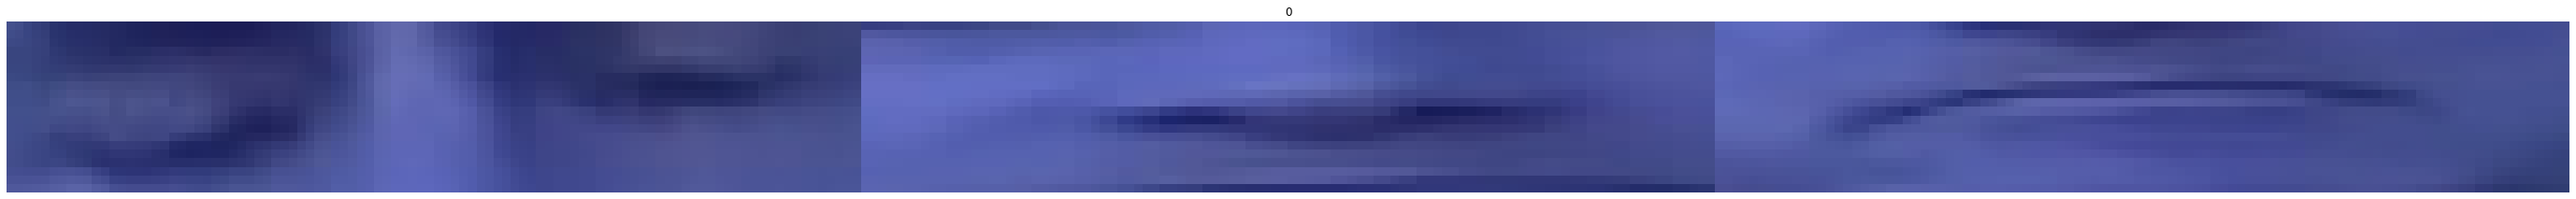

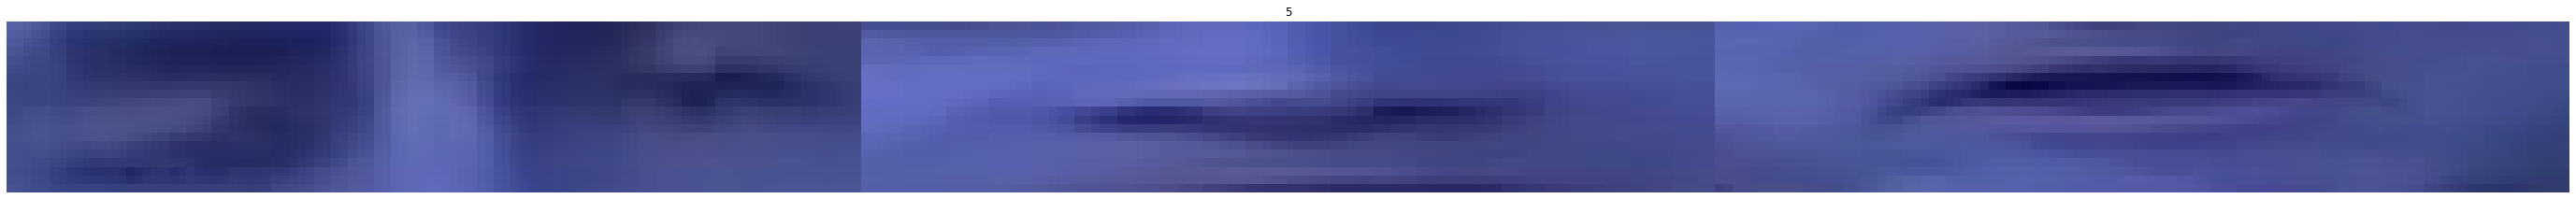

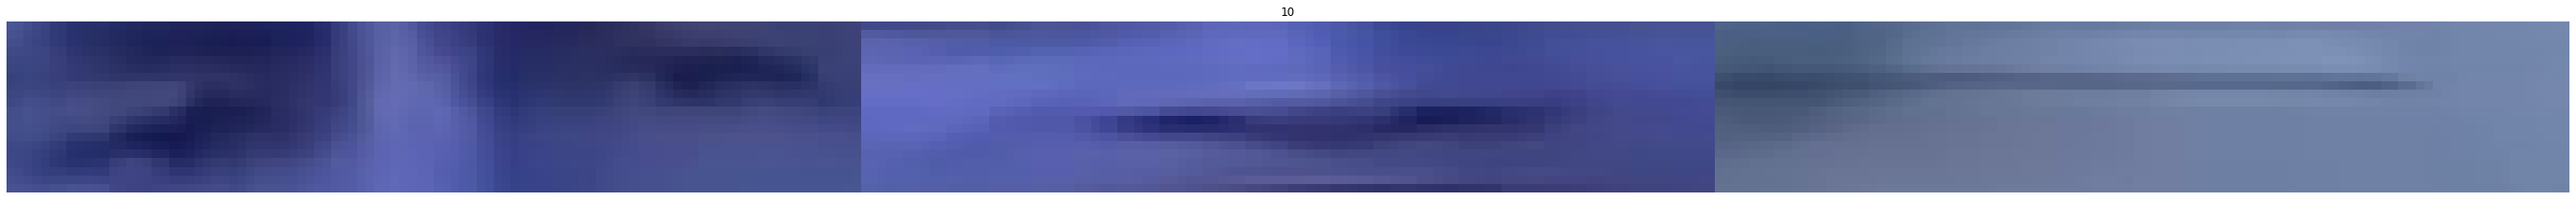

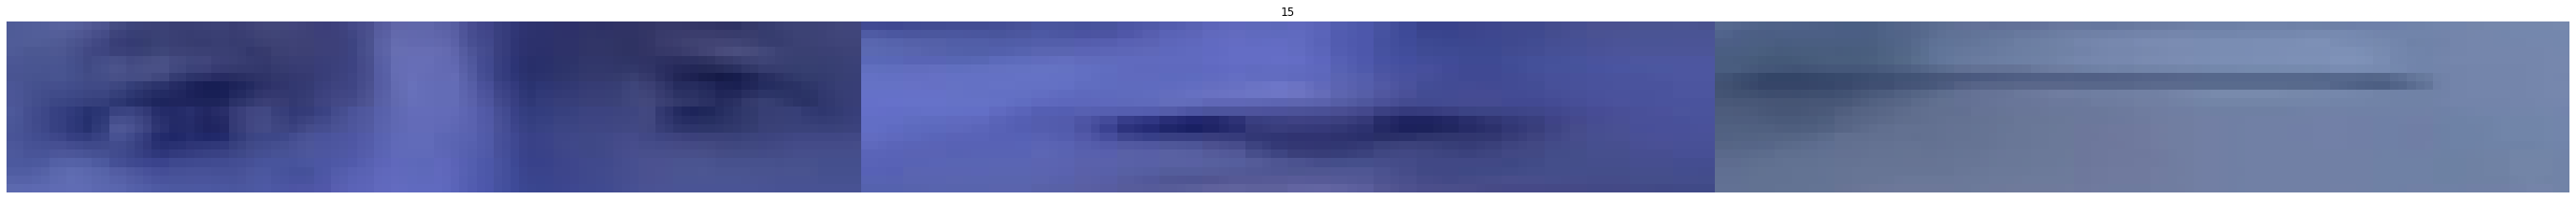

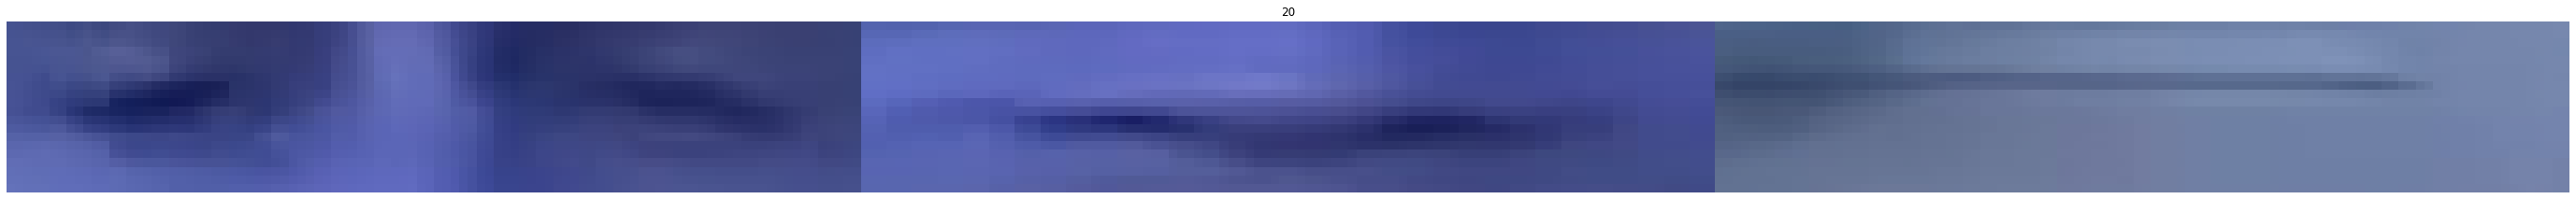

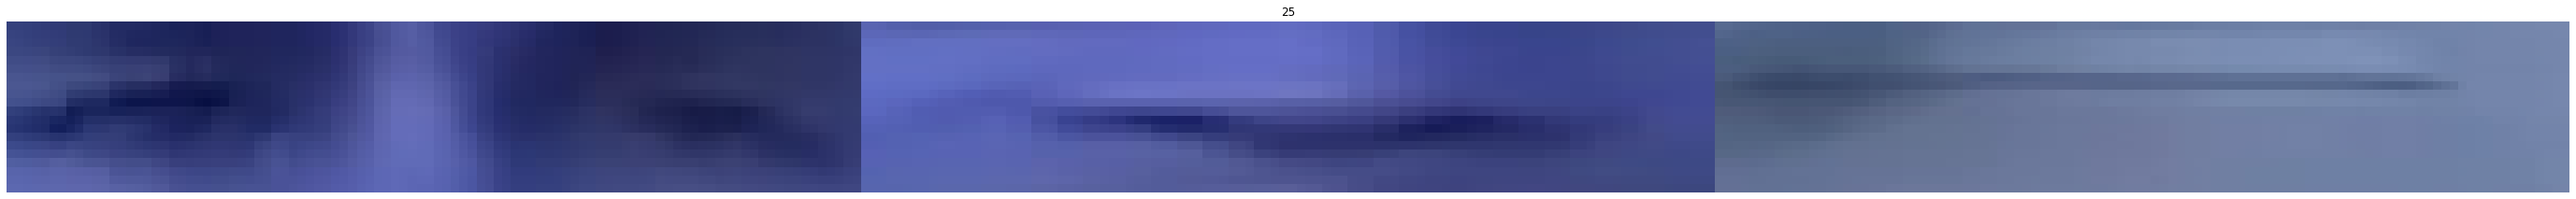

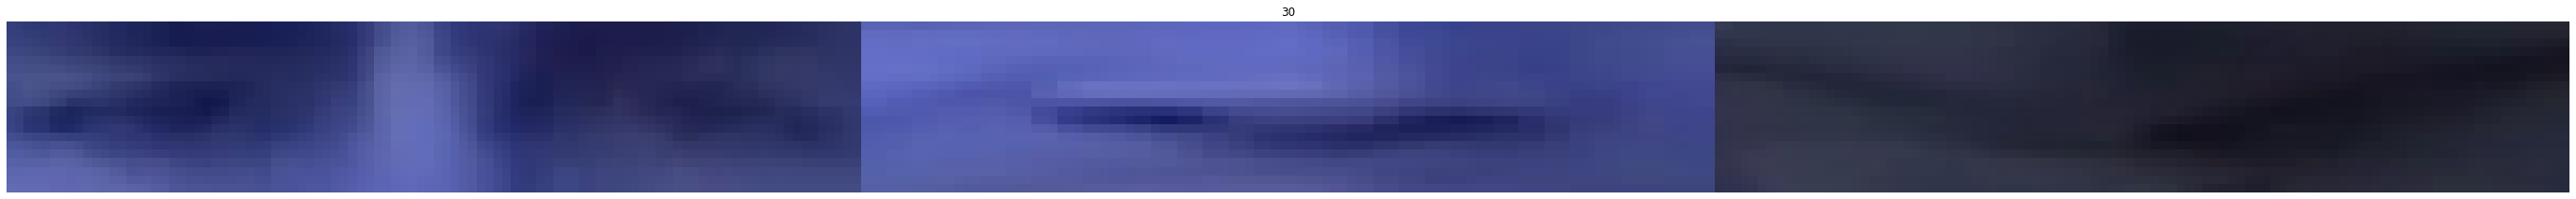

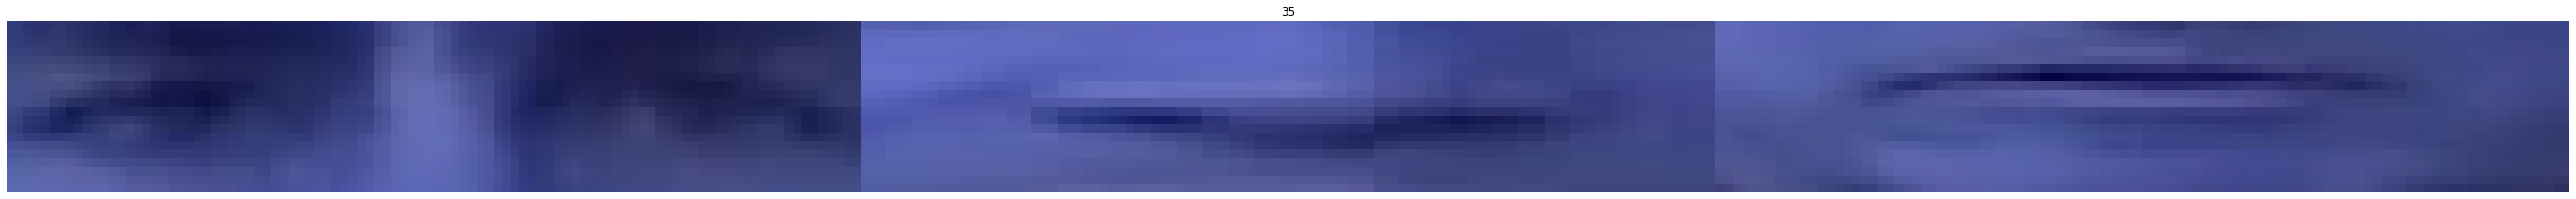

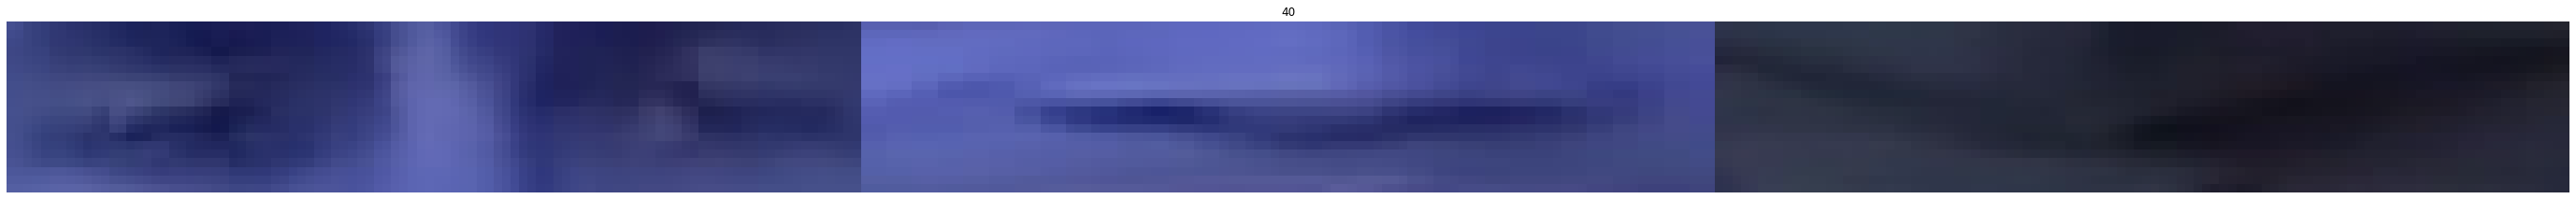

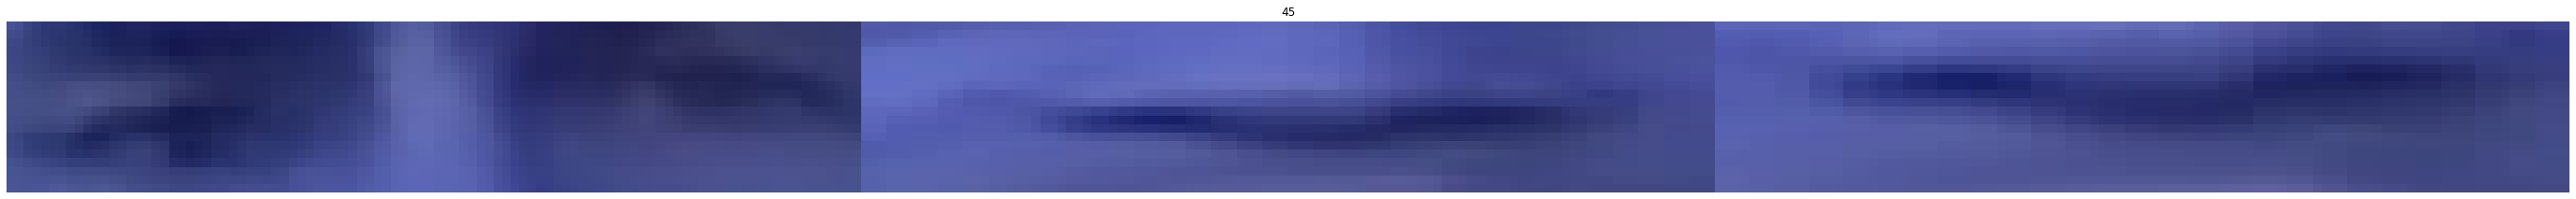

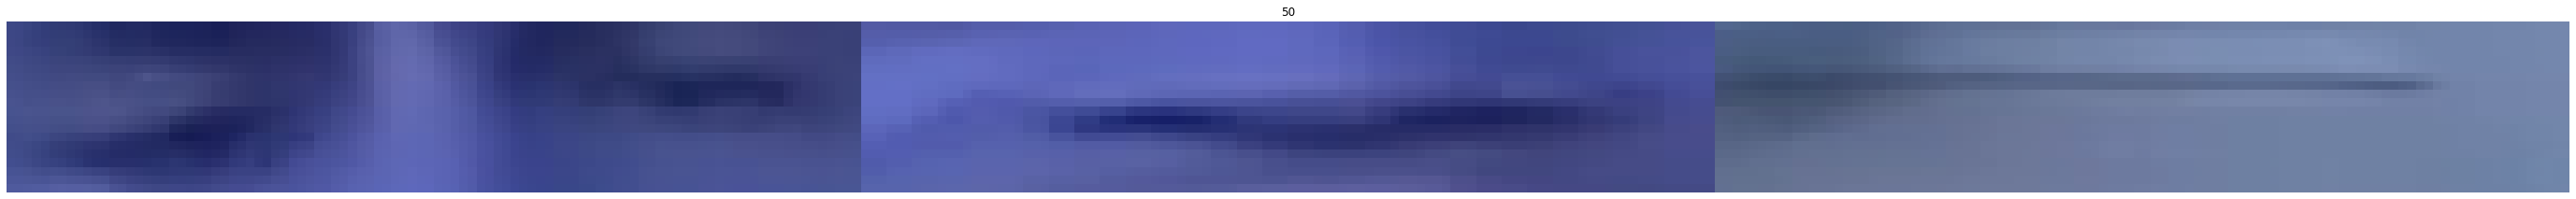

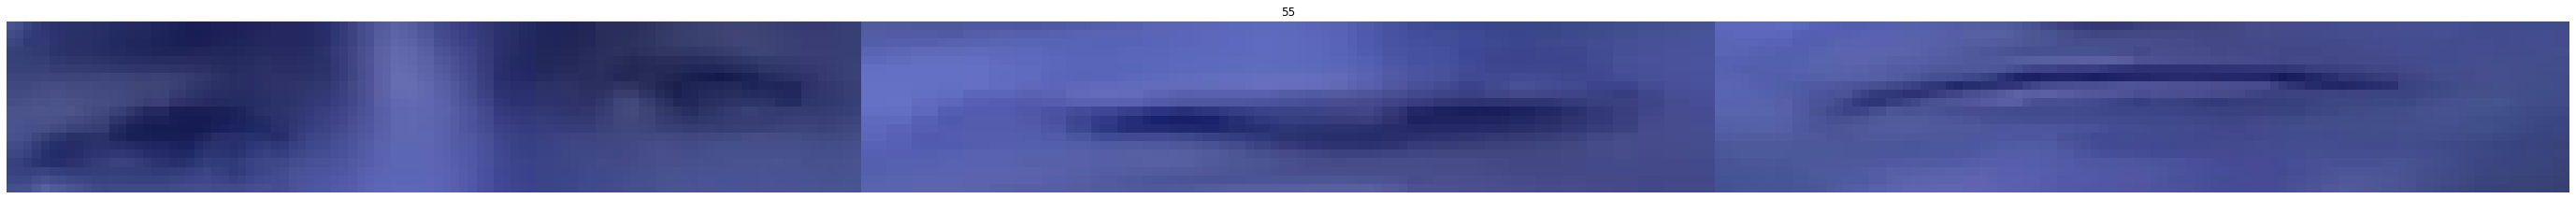

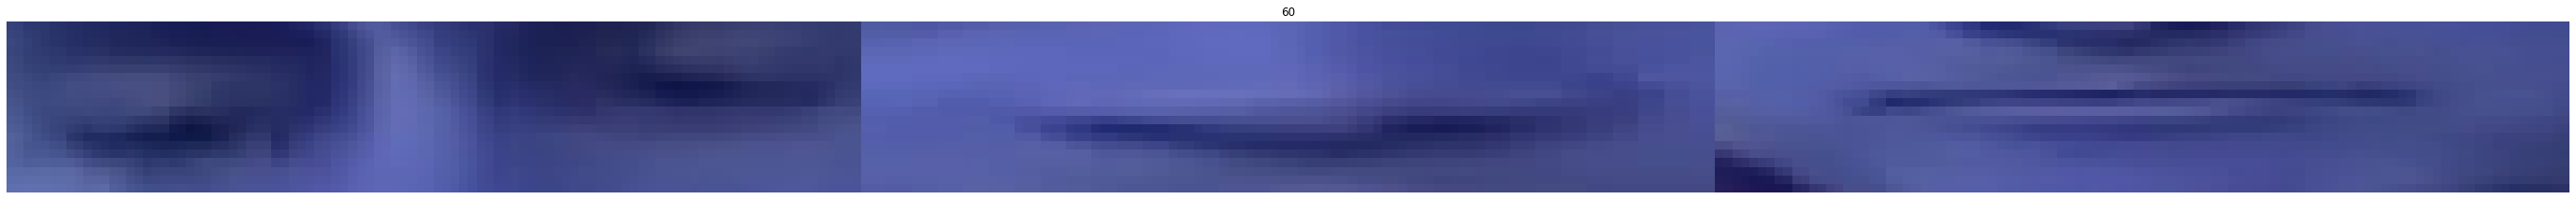

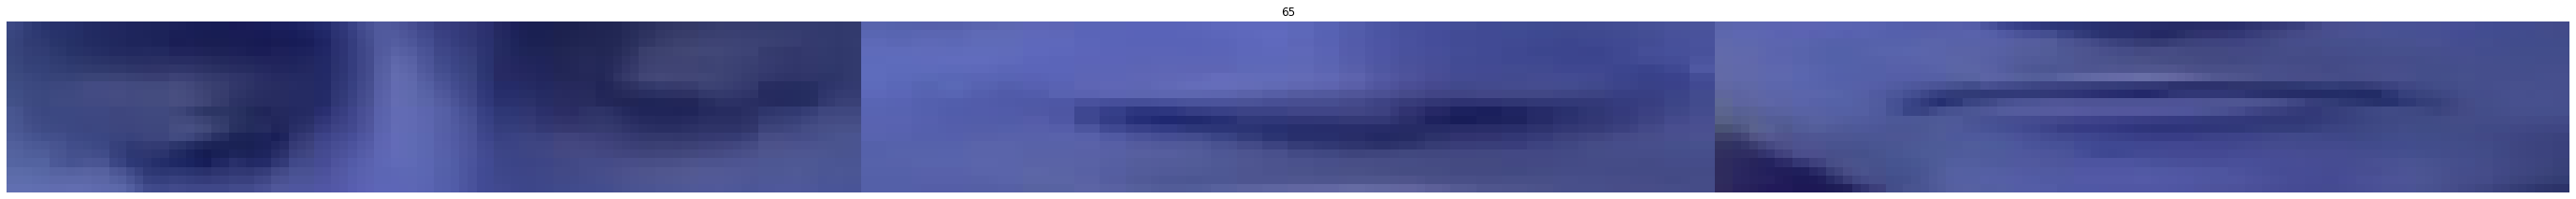

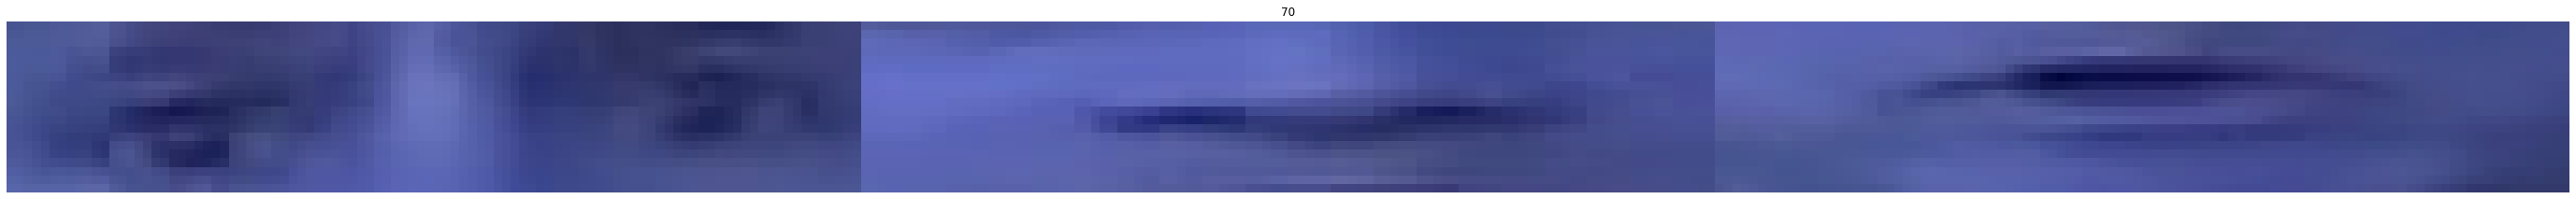

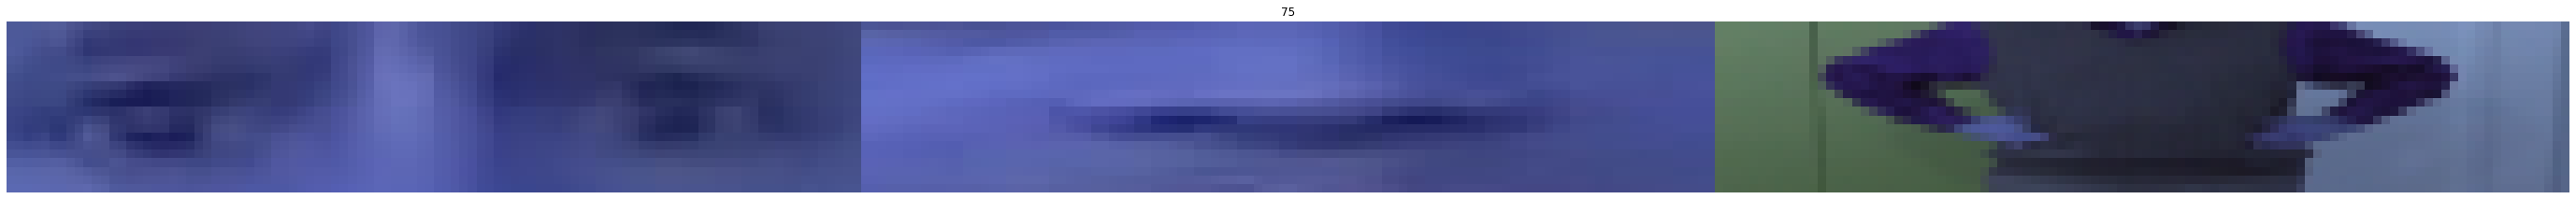

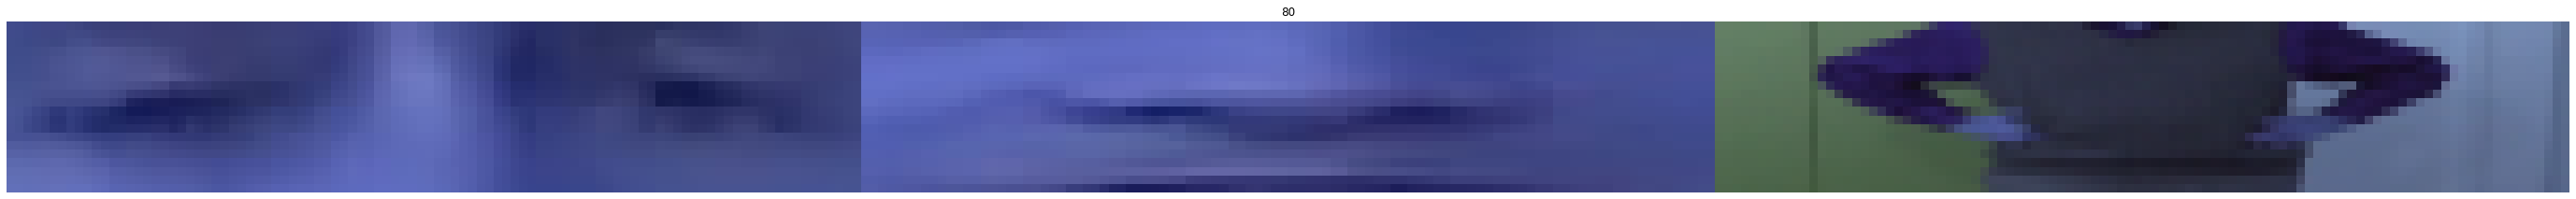

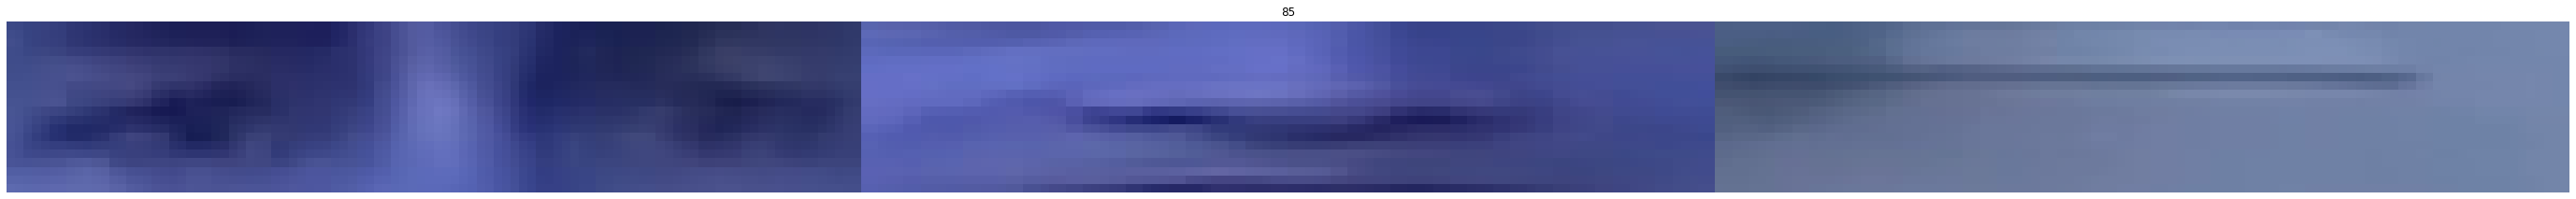

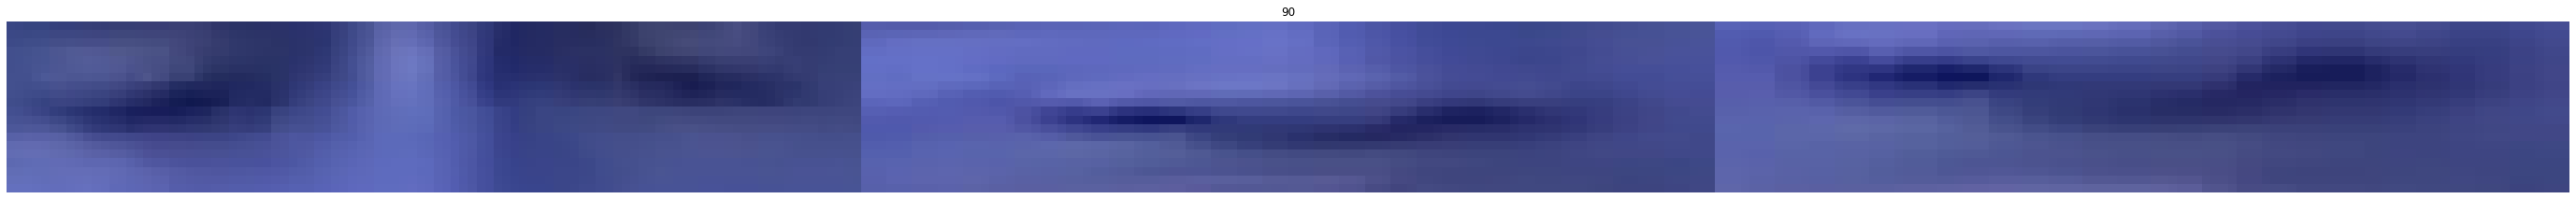

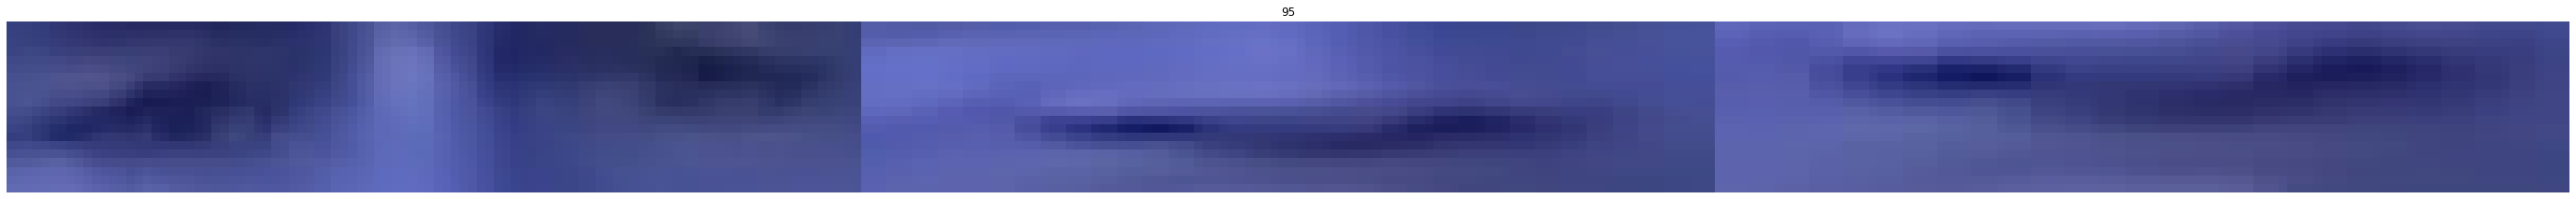

In [ ]:
%matplotlib inline
#input the video files and get 20 faces crop images
#if there's no face detection, return np.empty

#Extract face for each 5 frames. And get 20 face samples.
def crop_faces(fn,cnt_limit=20, plot=False, itr_limit = 250):
    faces=[]
    video_path = os.path.join(INPUT_PATH, fn)
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0
    itr = 0
    empty_faces = np.empty((20,100,100,3));empty_faces[:]=np.nan;
    while success:
        # Extract 20 faces
        itr+=1
        if itr>=itr_limit and count<cnt_limit*5:
            return empty_faces

        #every 5 frames, store captured face. if no face, continue capturing but don't count
        if count%5 ==0:
            face = extract_face(image)
            if np.isnan(face).any():
                success,image = vidcap.read()
                continue #if there's no face detected, then capture next face and not count do not increase
            else:
                faces.append(face)
                if plot:
                    plt.figure(figsize=(80,80))
                    plt.subplot(cnt_limit,1,int(count/5)+1)
                    plt.title(str(count))
                    plt.axis('off')
                    plt.imshow(face)
        success,image = vidcap.read()
        count += 1
        if count >=cnt_limit*5:
            break
    if len(faces)<cnt_limit:
        return empty_faces
    return np.asarray(faces)

fn = FILES[2]
frames = crop_faces(fn,plot=True)
print("frames size:",frames.shape)

In [ ]:
frames.shape

(20, 20, 300, 3)

In [ ]:
#check NaN Frames
np.isnan(frames).any()

False

In [ ]:
# make noise df of the image (3,20,300) -> (20,300)
def face_noise(img, NOISE_DEPTH=1):
    if np.isnan(img).any():
        empty_sf = np.empty((100,100))
        empty_sf[:]=np.nan
        return empty_sf
    else:
        img1 = img - cv2.GaussianBlur(img, (3,3), 0)
        imgs1 = np.sum(img1, axis=2)
        if NOISE_DEPTH == 1:
            sf = np.fft.fftshift(np.fft.fft2(imgs1))
            eps = np.max(sf) * 1e-2
            s1 = np.log(sf + eps) - np.log(eps) 
            sf = (s1 * 255 / np.max(s1))
            sf = np.abs(sf)
        else:
            sf = np.stack([
                 np.fft.fftshift(np.fft.fft2( imgs1 )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,0] - img1[:,:,1] )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,1] - img1[:,:,2] )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,2] - img1[:,:,0] ))],
                 axis=-1)
            sf = np.abs(sf)
            nchans = sf.shape[2]
            for c in range(nchans):
                eps = np.max(sf[:,:,c]) * 1e-2
                s1 = np.log(sf[:,:,c] + eps) - np.log(eps) 
                sf[:, :, c] = (s1 * 255 / np.max(s1))
        return sf.astype(np.float16)

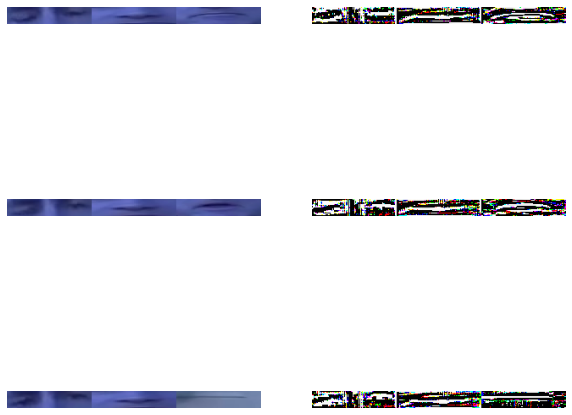

In [ ]:
%matplotlib inline
w=3
h=2
fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 3
for i in range(1, rows+1):
    img = frames[i-1]
    fig.add_subplot(rows, columns, columns*i-1)
    plt.imshow(img)
    plt.axis('off')
    img1 = img - cv2.GaussianBlur(img, (7,7), 0)
    fig.add_subplot(rows, columns, columns*i)
    plt.imshow(img1)
    plt.axis('off')
plt.show()

In [ ]:
# Make noise array of video to Learning
def build_features(f):
    frames = crop_faces(f,plot=False)
    if np.isnan(frames).any():
        empty_noise = np.empty((20,20,300))
        empty_noise[:]=np.nan
        return empty_noise
    noise = np.array(list(map(face_noise,frames)))
    return noise

In [ ]:
a = build_features(FILES[3])
a.shape

(20, 20, 300)

In [ ]:
# Make build Feature Set

tqdm.pandas()
n=1
gap = int(len(FILES)/4)
if n<4:
    FILES_store = FILES[range((n-1)*gap,n*gap)]
else:
    FILES_store = FILES[(n-1)*gap:]
all_video_fn = np.array(list(tqdm(map(build_features,FILES_store),
                     total=len(FILES_store), desc='Build Feature Set over FILES')))
np.save("video"+str(n)+".npy", all_video_fn)
print("video"+str(n)+".npy"+" Complete!")

   # Front Face

In [ ]:
# frontface feature

ar_1 = np.load('C:\\Users\\123\\Desktop/front_face/video1.npy')
ar_2 = np.load('C:\\Users\\123\\Desktop/front_face/video2.npy')
ar_3 = np.load('C:\\Users\\123\\Desktop/front_face/video3.npy')
ar_4 = np.load('C:\\Users\\123\\Desktop/front_face/video4.npy')
print(ar_1.shape)
print(ar_2.shape)
print(ar_3.shape)
print(ar_4.shape)

(100, 20, 100, 100)
(100, 20, 100, 100)
(100, 20, 100, 100)
(100, 20, 100, 100)


   ## CNN

In [ ]:
feature_set = np.concatenate((ar_1, ar_2, ar_3, ar_4))
labels_set = np.array(LABELS[0:feature_set.shape[0]])
pos = np.where(labels_set=='REAL')
labels_set = np.zeros(shape=(feature_set.shape[0],1))
labels_set[pos[0],0]=1
print(labels_set[0:5,:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# Eliminate positions with np.nan values
all_pos=[]; real_pos=[]; fake_pos=[];
for i in range(0,feature_set.shape[0]):
    a = np.isnan(feature_set[i,:,:,:]).any()
    if not a:
        all_pos.append(i)
        if i in pos[0]:
            real_pos.append(i)
        else:
            fake_pos.append(i)
print(feature_set.shape[0]-len(all_pos),"videos are dropped out of",feature_set.shape[0])
print("real videos:",len(real_pos))
print("fake videos:",len(fake_pos))

79 videos are dropped out of 400
real videos: 39
fake videos: 282


In [ ]:
random.shuffle(real_pos)
random.shuffle(fake_pos)

In [ ]:
training_ix = real_pos[0:int(len(real_pos)*0.5+1)]*4+fake_pos[0:int(len(fake_pos)*0.7+1)]
remain_real_pos = [j for j in real_pos if j not in training_ix]
remain_fake_pos = [j for j in fake_pos if j not in training_ix]
test_ix = remain_real_pos+remain_fake_pos
##
random.shuffle(training_ix)
random.shuffle(test_ix)
X_train = feature_set[training_ix,:,:,:]
y_train = labels_set[training_ix,:]
X_test = feature_set[test_ix,:,:,:]
y_test = labels_set[test_ix,:]

In [ ]:
print("label <real> in train set:",len(y_train[y_train==1]))
print("label <real> in test set:",len(y_test[y_test==1]))

label <real> in train set: 80
label <real> in test set: 19


In [ ]:
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (278, 20, 100, 100)
y_train: (278, 1)
X_test: (103, 20, 100, 100)
y_test: (103, 1)


In [ ]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=3)]
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(16).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(16).prefetch(10)

In [ ]:
model = tfk.Sequential()

#Block 1
#smooth stride; padding: handle edges;
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), 
                      padding="valid", activation='tanh', input_shape=(20, 100, 100)))
model.add(tfkl.MaxPool2D(pool_size=(1,2)))

#Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu'))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu'))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 6, 33, 20)         18020     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 16, 20)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 15, 16)         1296      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 14, 8)          520       
_________________________________________________________________
global_max_pooling2d_12 (Glo (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 19,845
Trainable params: 19,845
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=["acc"]
)

In [ ]:
results = model.fit(ds_train, steps_per_epoch=10,epochs=20,
                    callbacks=cbs, verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/20
10/10 [==============================] - 1s 53ms/step - loss: 0.6761 - acc: 0.6250 - val_loss: 0.5246 - val_acc: 0.8750
Epoch 2/20
10/10 [==============================] - 0s 32ms/step - loss: 0.5975 - acc: 0.7467 - val_loss: 0.4998 - val_acc: 0.8750
Epoch 3/20
10/10 [==============================] - 0s 25ms/step - loss: 0.6209 - acc: 0.6938 - val_loss: 0.4257 - val_acc: 0.8750
Epoch 4/20
10/10 [==============================] - 0s 45ms/step - loss: 0.5919 - acc: 0.7200 - val_loss: 0.4777 - val_acc: 0.8750
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 0.6010 - acc: 0.7125 - val_loss: 0.4991 - val_acc: 0.8750
Epoch 6/20
10/10 [==============================] - 0s 25ms/step - loss: 0.5996 - acc: 0.7200 - val_loss: 0.4579 - val_acc: 0.8750


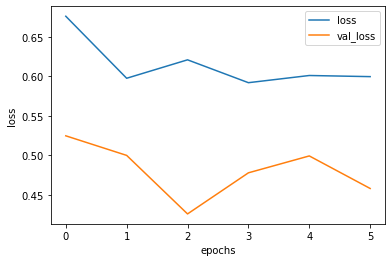

In [ ]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["loss", "val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print(test_acc)
print(test_loss)

7/7 [==============================] - 0s 16ms/step - loss: 0.5112 - acc: 0.8155
0.8155339956283569
0.5112155675888062


## GRU

In [ ]:
print(feature_set[all_pos].shape)
print(labels_set[all_pos].shape)

(321, 20, 100, 100)
(321, 1)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(278, 20, 100, 100)
(103, 20, 100, 100)


In [ ]:
xx_train = X_train.reshape(278,20,10000,1)
xx_train = np.ndarray.mean(xx_train,axis=2)
print(xx_train.shape)
xx_test = X_test.reshape(103,20,10000,1)
xx_test = np.ndarray.mean(xx_test,axis=2)
print(xx_test.shape)

(278, 20, 1)
(103, 20, 1)


In [ ]:
gru_feature_set = feature_set[all_pos].reshape(321,20,10000,1)
gru_feature_set = np.ndarray.mean(gru_feature_set,axis=2)
print(gru_feature_set.shape)
gru_labels_set = labels_set[all_pos]
print(gru_labels_set.shape)

(321, 20, 1)
(321, 1)


In [ ]:
#cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=3)]
gru_ds_train = tf.data.Dataset.from_tensor_slices((xx_train,y_train)).batch(16).repeat().prefetch(10) 
gru_ds_test = tf.data.Dataset.from_tensor_slices((xx_test,y_test)).batch(16).prefetch(10)

In [ ]:
# The GRU architecture
GRU_mod = Sequential()
# First GRU layer with Dropout regularisation
GRU_mod.add(GRU(units=20, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Second GRU layer
GRU_mod.add(GRU(units=50, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Third GRU layer
GRU_mod.add(GRU(units=30, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Fourth GRU layer
GRU_mod.add(GRU(units=10, activation='tanh'))
GRU_mod.add(Dropout(0.2))
# The output layer
GRU_mod.add(Dense(units=1,activation='sigmoid'))
GRU_mod.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 20, 20)            1380      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 20, 50)            10800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 20, 30)            7380      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 10)              

In [ ]:
# Fitting with Train Set

GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output1 =  GRU_mod.fit(xx_train,y_train,epochs=50,batch_size=16)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
18/18 [==============================] - 5s 19ms/step - loss: 0.6652 - acc: 0.6547
Epoch 2/50
18/18 [==============================] - 0s 19ms/step - loss: 0.6377 - acc: 0.7014
Epoch 3/50
18/18 [==============================] - 0s 18ms/step - loss: 0.6112 - acc: 0.7122
Epoch 4/50
18/18 [==============================] - 0s 19ms/step - loss: 0.5987 - acc: 0.7122
Epoch 5/50
18/18 [==============================] - 0s 20ms/step - loss: 0.6135 - acc: 0.7122
Epoch 6/50
18/18 [==============================] - 0s 19ms/step - loss: 0.6059 - acc: 0.7122
Epoch 7/50
18/18 [==============================] - 0s 20ms/step - loss: 0.6007 - acc: 0.7122
Epoch 8/50
18/18 [==============================] - 0s 20ms/step - loss: 0.6192 - acc: 0.7122
Epoch 9/50
18/18 [==============================] - 0s 19ms/step - loss: 0.6062 - acc: 0.7122
Epoch 10/50
18/18 [==============================] - 0s 19ms/step - loss: 0.6111 - acc: 0.7122
Epoch 11/50
18/18 [==============================] - 0s 20m

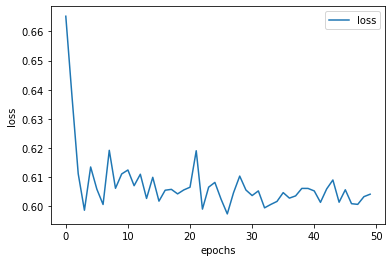

In [ ]:
plt.plot(output1.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Fitting with Feature Set

GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output3 =  GRU_mod.fit(gru_feature_set,gru_labels_set,epochs=50,batch_size=16)

Epoch 1/50
21/21 [==============================] - 5s 21ms/step - loss: 0.3702 - acc: 0.8785
Epoch 2/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3713 - acc: 0.8785
Epoch 3/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3780 - acc: 0.8785
Epoch 4/50
21/21 [==============================] - 0s 20ms/step - loss: 0.3834 - acc: 0.8785
Epoch 5/50
21/21 [==============================] - 0s 21ms/step - loss: 0.3732 - acc: 0.8785
Epoch 6/50
21/21 [==============================] - 0s 20ms/step - loss: 0.3774 - acc: 0.8785
Epoch 7/50
21/21 [==============================] - 0s 20ms/step - loss: 0.3690 - acc: 0.8785
Epoch 8/50
21/21 [==============================] - 0s 20ms/step - loss: 0.3730 - acc: 0.8785
Epoch 9/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3762 - acc: 0.8785
Epoch 10/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3712 - acc: 0.8785
Epoch 11/50
21/21 [==============================] - 0s 19m

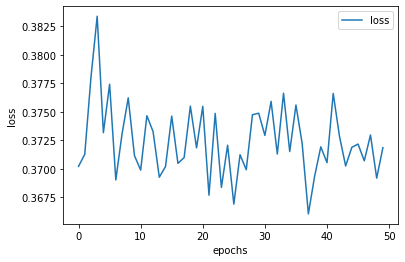

In [ ]:
plt.plot(output3.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_loss, test_acc = GRU_mod.evaluate(gru_ds_test)
print(test_acc)
print(test_loss)

7/7 [==============================] - 1s 5ms/step - loss: 0.4872 - acc: 0.8155
0.8155339956283569
0.4871961772441864


# Face (Eyes, Nose, Mouth)

In [ ]:
# face feature that only contains mouth, nose, eyes

ar_1 = np.load('C:\\Users\\123\\Desktop/video1.npy')
ar_2 = np.load('C:\\Users\\123\\Desktop/video2.npy')
ar_3 = np.load('C:\\Users\\123\\Desktop/video3.npy')
ar_4 = np.load('C:\\Users\\123\\Desktop/video4.npy')
print(ar_1.shape)
print(ar_2.shape)
print(ar_3.shape)
print(ar_4.shape)

(783, 20, 20, 300)
(783, 20, 20, 300)
(783, 20, 20, 300)
(785, 20, 20, 300)


## CNN

In [ ]:
feature_set = np.concatenate((ar_1, ar_2, ar_3, ar_4))
labels_set = np.array(LABELS[0:feature_set.shape[0]])
pos = np.where(labels_set=='REAL')
labels_set = np.zeros(shape=(feature_set.shape[0],1))
labels_set[pos[0],0]=1
print(labels_set[0:5,:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
#eliminate positions with np.nan values
all_pos=[]; real_pos=[]; fake_pos=[];
for i in range(0,feature_set.shape[0]):
    a = np.isnan(feature_set[i,:,:,:]).any()
    if not a:
        all_pos.append(i)
        if i in pos[0]:
            real_pos.append(i)
        else:
            fake_pos.append(i)
print(feature_set.shape[0]-len(all_pos),"videos are dropped out of",feature_set.shape[0])
print("real videos:",len(real_pos))
print("fake videos:",len(fake_pos))

1695 videos are dropped out of 3134
real videos: 154
fake videos: 1285


In [ ]:
random.shuffle(real_pos)
random.shuffle(fake_pos)

In [ ]:
training_ix = real_pos[0:int(len(real_pos)*0.5+1)]*4+fake_pos[0:int(len(fake_pos)*0.7+1)]
remain_real_pos = [j for j in real_pos if j not in training_ix]
remain_fake_pos = [j for j in fake_pos if j not in training_ix]
test_ix = remain_real_pos+remain_fake_pos

random.shuffle(training_ix)
random.shuffle(test_ix)
X_train = feature_set[training_ix,:,:,:]
y_train = labels_set[training_ix,:]
X_test = feature_set[test_ix,:,:,:]
y_test = labels_set[test_ix,:]

In [ ]:
print("label <real> in train set:",len(y_train[y_train==1]))
print("label <real> in test set:",len(y_test[y_test==1]))

label <real> in train set: 312
label <real> in test set: 76


In [ ]:
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (1212, 20, 20, 300)
y_train: (1212, 1)
X_test: (461, 20, 20, 300)
y_test: (461, 1)


In [ ]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=3)]
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(16).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(16).prefetch(10)

In [ ]:
model = tfk.Sequential()

#Block 1
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), 
                      padding="valid", activation='tanh', input_shape=(20, 20, 300))) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=(1,2)))

#Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
#model.add(tfkl.MaxPool2D(pool_size=2))
#model.add(tfkl.Dropout(.2))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
#model.add(tfkl.MaxPool2D(pool_size=2))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 6, 6, 20)          54020     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 3, 20)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 5, 2, 16)          1296      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 4, 1, 8)           520       
_________________________________________________________________
global_max_pooling2d_13 (Glo (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 55,845
Trainable params: 55,845
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=["acc"]
)

In [ ]:
results = model.fit(ds_train, steps_per_epoch=10,epochs=20,
                    callbacks=cbs, verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/20
10/10 [==============================] - 1s 37ms/step - loss: 0.6524 - acc: 0.6562 - val_loss: 0.4178 - val_acc: 0.9375
Epoch 2/20
10/10 [==============================] - 0s 33ms/step - loss: 0.5131 - acc: 0.8062 - val_loss: 0.3418 - val_acc: 0.9375
Epoch 3/20
10/10 [==============================] - 0s 25ms/step - loss: 0.5677 - acc: 0.7500 - val_loss: 0.3556 - val_acc: 0.9375
Epoch 4/20
10/10 [==============================] - 0s 29ms/step - loss: 0.5365 - acc: 0.7750 - val_loss: 0.3409 - val_acc: 0.9375
Epoch 5/20
10/10 [==============================] - 0s 29ms/step - loss: 0.6401 - acc: 0.6750 - val_loss: 0.4349 - val_acc: 0.9375


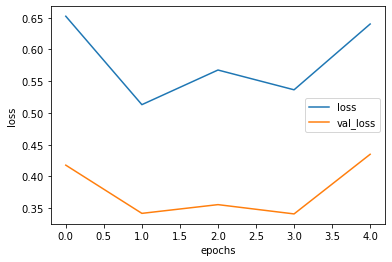

In [ ]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["loss", "val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(ds_test)
print(test_acc)
print(test_loss)

29/29 [==============================] - 1s 11ms/step - loss: 0.5112 - acc: 0.8351
0.8351410031318665
0.5112091898918152


## GRU

In [ ]:
print(feature_set[all_pos].shape)
print(labels_set[all_pos].shape)

(1439, 20, 20, 300)
(1439, 1)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(1212, 20, 20, 300)
(461, 20, 20, 300)


In [ ]:
xx_train = X_train.reshape(1212,20,6000,1)
xx_train = np.ndarray.mean(xx_train,axis=2)
print(xx_train.shape)
xx_test = X_test.reshape(461,20,6000,1)
xx_test = np.ndarray.mean(xx_test,axis=2)
print(xx_test.shape)

(1212, 20, 1)
(461, 20, 1)


In [ ]:
gru_feature_set = feature_set[all_pos].reshape(1439,20,6000,1)
gru_feature_set = np.ndarray.mean(gru_feature_set,axis=2)
print(gru_feature_set.shape)
gru_labels_set = labels_set[all_pos]
print(gru_labels_set.shape)

(1439, 20, 1)
(1439, 1)


In [ ]:
gru_ds_train = tf.data.Dataset.from_tensor_slices((xx_train,y_train)).batch(16).repeat().prefetch(10) 
gru_ds_test = tf.data.Dataset.from_tensor_slices((xx_test,y_test)).batch(16).prefetch(10)

In [ ]:
# The GRU architecture
GRU_mod = Sequential()
# First GRU layer with Dropout regularisation
GRU_mod.add(GRU(units=20, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Second GRU layer
GRU_mod.add(GRU(units=50, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Third GRU layer
GRU_mod.add(GRU(units=30, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Fourth GRU layer
GRU_mod.add(GRU(units=10, activation='tanh'))
GRU_mod.add(Dropout(0.2))
# The output layer
GRU_mod.add(Dense(units=1,activation='sigmoid'))
GRU_mod.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 20, 20)            1380      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 20, 50)            10800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_10 (GRU)                 (None, 20, 30)            7380      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 30)            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 10)              

In [ ]:
GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output1 =  GRU_mod.fit(xx_train,y_train,epochs=50,batch_size=16)

Epoch 1/50
76/76 [==============================] - 6s 21ms/step - loss: 0.5907 - acc: 0.7310
Epoch 2/50
76/76 [==============================] - 2s 20ms/step - loss: 0.5802 - acc: 0.7426
Epoch 3/50
76/76 [==============================] - 2s 21ms/step - loss: 0.5830 - acc: 0.7426
Epoch 4/50
76/76 [==============================] - 2s 21ms/step - loss: 0.5749 - acc: 0.7426
Epoch 5/50
76/76 [==============================] - 2s 20ms/step - loss: 0.5737 - acc: 0.7426
Epoch 6/50
76/76 [==============================] - 1s 20ms/step - loss: 0.5748 - acc: 0.7426
Epoch 7/50
76/76 [==============================] - 2s 20ms/step - loss: 0.5779 - acc: 0.7426
Epoch 8/50
76/76 [==============================] - 2s 21ms/step - loss: 0.5736 - acc: 0.7426
Epoch 9/50
76/76 [==============================] - 2s 21ms/step - loss: 0.5753 - acc: 0.7426
Epoch 10/50
76/76 [==============================] - 2s 21ms/step - loss: 0.5712 - acc: 0.7426
Epoch 11/50
76/76 [==============================] - 2s 21m

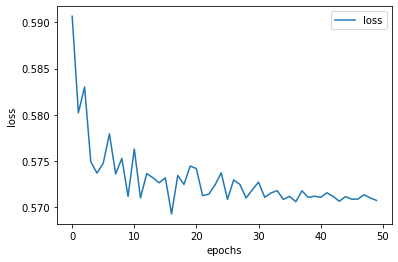

In [ ]:
plt.plot(output1.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output3 =  GRU_mod.fit(gru_feature_set,gru_labels_set,epochs=50,batch_size=16)

Epoch 1/50
90/90 [==============================] - 6s 20ms/step - loss: 0.3572 - acc: 0.8930
Epoch 2/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3431 - acc: 0.8930
Epoch 3/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3414 - acc: 0.8930
Epoch 4/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3431 - acc: 0.8930
Epoch 5/50
90/90 [==============================] - 2s 21ms/step - loss: 0.3390 - acc: 0.8930
Epoch 6/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3429 - acc: 0.8930
Epoch 7/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3403 - acc: 0.8930
Epoch 8/50
90/90 [==============================] - 2s 21ms/step - loss: 0.3420 - acc: 0.8930
Epoch 9/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3403 - acc: 0.8930
Epoch 10/50
90/90 [==============================] - 2s 20ms/step - loss: 0.3403 - acc: 0.8930
Epoch 11/50
90/90 [==============================] - 2s 20m

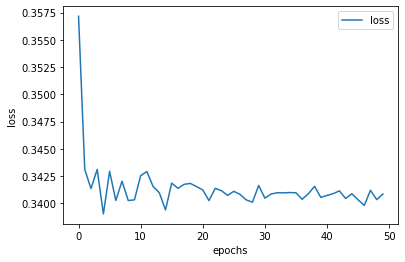

In [ ]:
plt.plot(output3.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_loss2, test_acc2 = GRU_mod.evaluate(gru_ds_test)
print(test_acc2)
print(test_loss2)

29/29 [==============================] - 1s 4ms/step - loss: 0.4620 - acc: 0.8351
0.8351410031318665
0.4620398283004761


# [8] **Result and Insights**

We compare the four cases: Two different preprocessing approach and two models

1.  Only extract (Eye, Nose, Mouth) with CNN Model 
*   Accuracy: 0.8351
*   Loss: 0.5112

2.  Only extract (Eye, Nose, Mouth) with GRU Model 
*   Accuracy: 0.8351
*   Loss: 0.4620

3.  Extract entire Face with CNN Model
*   Accuracy: 0.8155
*   Loss: 0.5112

4.  Extract entire Face with GRU Model
*   Accuracy: 0.8155
*   Loss: 0.4871

## Conclusion: 
Among the two different **preprocessing approaches**, We know that...

Building feature sets by focusing only on the eye, nose, and mouth areas shows better performance in deep fake detection than by extracting the entire face.

And in terms of **model** we adopted for deepfake detection task, GRU model shows better performance than CNN model.

# [9] **References**

(Face Cascade)
https://github.com/opencv/opencv/tree/master/data/haarcascades

(Face Discrete Fourier Transform)
https://leechamin.tistory.com/266



# **[10] Member's contribution**

### Hwang Donggyu: 

*   Build Feature sets using first preprocessing approach (eyes, nose, mouth only)
*   Code Implement using his own GPU (1070ti 6gb)

### Park JeongHa: 
*   Build Feature sets using second preprocessing approach (entire face)
*   Exploring related technologies and research


# [11] Github Repository

https://github.com/parkjungha/AI_TeamProject



